# Projeto Marinha do Brasil

## Laboratorio de Processamento de Sinais - UFRJ

#### Autor: Vinícius dos Santos Mello (viniciudsmello@poli.ufrj.br)

In [1]:
import os
import pickle
import numpy as np
import time

from keras.utils import np_utils
from keras.models import load_model

import sklearn.metrics
from sklearn.externals import joblib

import matplotlib.pyplot as plt

from Functions import TrainParameters as trnparams
from Functions import TrainFunctions

import multiprocessing 

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'StackedAutoEncoder'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/pictures_files'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# For multiprocessing purpose
num_processes = multiprocessing.cpu_count()

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = False
development_events = 400

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

#     balanced_data = {}
#     balanced_trgt = {}

#     from Functions import DataHandler as dh
#     m_datahandler = dh.DataHandlerFunctions()

#     for iclass, class_label in enumerate(class_labels):
#         if development_flag:
#             class_events = all_data[all_trgt==iclass,:]
#             if len(balanced_data) == 0:
#                 balanced_data = class_events[0:development_events,:]
#                 balanced_trgt = (iclass)*np.ones(development_events)
#             else:
#                 balanced_data = np.append(balanced_data,
#                                           class_events[0:development_events,:], 
#                                           axis=0)
#                 balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
#         else:
#             if len(balanced_data) == 0:
#                 class_events = all_data[all_trgt==iclass,:]
#                 balanced_data = m_datahandler.CreateEventsForClass(
#                     class_events,qtd_events_biggest_class-(len(class_events)))
#                 balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
#             else:
#                 class_events = all_data[all_trgt==iclass,:]
#                 created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
#                                                                      qtd_events_biggest_class-
#                                                                      (len(class_events))))
#                 balanced_data = np.append(balanced_data,created_events,axis=0)
#                 balanced_trgt = np.append(balanced_trgt,
#                                           (iclass)*np.ones(created_events.shape[0]),axis=0)
        
#     all_data = balanced_data
#     all_trgt = balanced_trgt

#     # turn targets in sparse mode
#     from keras.utils import np_utils
#     trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Using Theano backend.
/home/vinicius.mello/.virtualenvs/sonarenv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Time to import all libraries: 6.50882720947e-05 seconds
Time to read data file: 1.27910494804 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events


In [2]:
print data.shape
print all_data.shape

(77561, 400)
(77561, 400)


In [31]:
%%time
# load parameters

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=128,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

n_folds = 2
CVO = trnparams.ClassificationFolds(folder=results_path,
                                    n_folds=n_folds,
                                    trgt=all_trgt,
                                    dev=development_flag, verbose=False)
print trn_params.get_params_str()

1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation
CPU times: user 7.73 ms, sys: 0 ns, total: 7.73 ms
Wall time: 10.3 ms


## Treinamento com processamento paralelo

In [32]:
%%time
# To train on multiple cores sweeping the number of folds
def trainFold(ifold):
    ineuron = 20
    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [33]:
%time
p = multiprocessing.Pool(processes=num_processes+1)
start_time = time.time()
folds = range(len(CVO))
neurons = [0,100,200] + [300,350,400,450]
neurons.sort() # Train from 0 to 750
# To train on multiple cores sweeping the number of folds
#results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
It took 0.106 seconds to perform the training


In [21]:
print end_time/3600

2.91050142712e-05


# Análises com variação de Neurônios

/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_400x1_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_400x100_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_400x200_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_128_batch_size_tanh_hidden_activation_linear_output_activation_400x300_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder

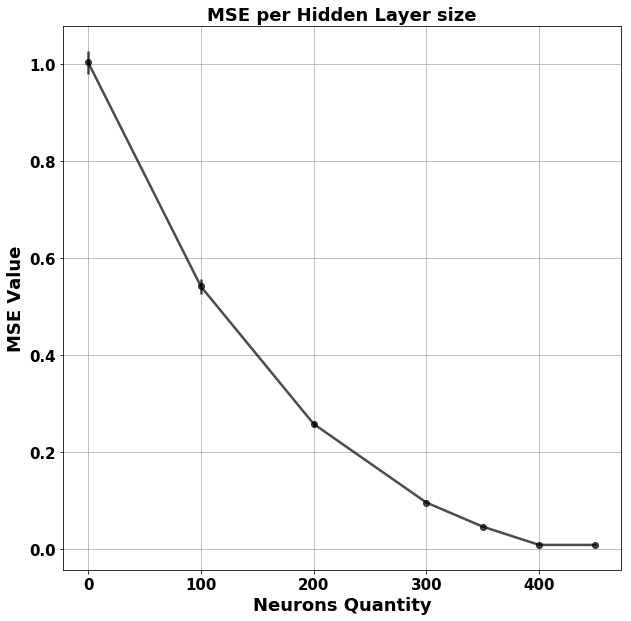

In [34]:
# Neuron variation x MSE

from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mse'

analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)

os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                             hidden_activation='relu',
                                                             output_activation='linear',
                                                             n_epochs=500,
                                                             patience=30,
                                                             batch_size=128,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    neurons_mat = neurons
    neurons_mat.sort()
    
    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data[test_id,:])

        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1
            model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                                       model_prefix_str,
                                                       n_folds,
                                                       params_str,
                                                       neuron_value)

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
            print file_name
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = neuron_value
                    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                            trgt=all_data,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag)
                
                p = multiprocessing.Pool(processes=num_processes)
                folds = range(len(CVO))
                results = p.map(trainFold, folds)
                p.close()
                p.join()
                
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = metrics.mean_squared_error(norm_data, output)
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 
ax.grid()
#Save the figure
file_name = pict_results_path+'/'+current_analysis+'_first_layer_'+trn_params.get_params_str()+'.pdf'
plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

In [23]:
# Analysis of Reconstruction Input x Output

import matplotlib.pyplot as plt
%matplotlib inline  

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'reconstruction_inputxoutput'
# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3

# Number of neurons at first layer
ineuron = 400

models = {}
outputs = {}
mean = {}
indexes = {}

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])
    if ifold == 0:
        diffSquared = np.zeros([len(CVO),norm_data.shape[0],norm_data.shape[1]])
    # Get the model file
    model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                               model_prefix_str,
                                               n_folds,
                                               params_str,
                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)

    if not os.path.exists(file_name):
        def trainFold(ifold):
            return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                    trgt=all_data,
                                    ifold=ifold,
                                    n_folds=n_folds, 
                                    n_neurons=ineuron,
                                    trn_params=trn_params, 
                                    save_path=results_path,
                                    dev=development_flag)
        
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    models[ifold]  = load_model(file_name)
    outputs[ifold] = models[ifold].predict(norm_data) 

    diffSquared[ifold] = np.power((norm_data - outputs[ifold]), 2) 

mean = np.mean(np.mean(diffSquared, axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(len(CVO)):
    points = norm_data.shape[0]
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):
        ax = plt.subplot(2,2,choose_index+1)
        ax.plot(norm_data[:,indexes[choose_index]][:points], outputs[ifold][:,indexes[choose_index]][:points],"b.")
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')
        plt.legend()
        plt.grid()    
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_first_layer_%i_neurons_%i_fold_'%(ineuron,ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

ValueError: could not broadcast input array from shape (38780,400) into shape (38781,400)

# Análise LOFAR para reconstrução da 1ª Camada

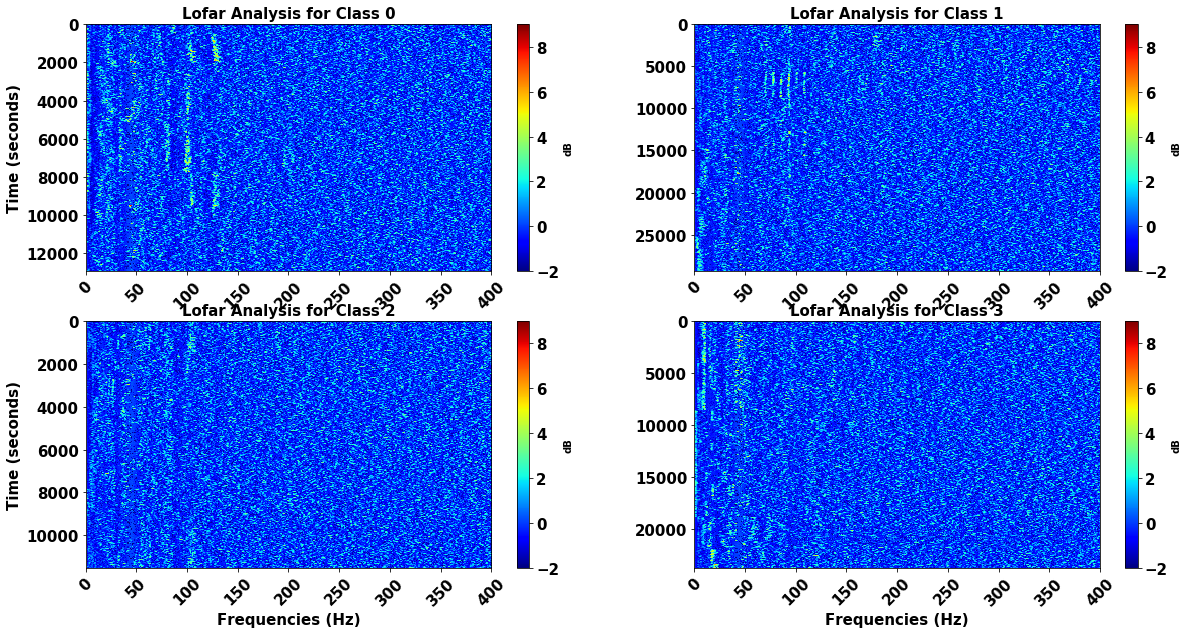

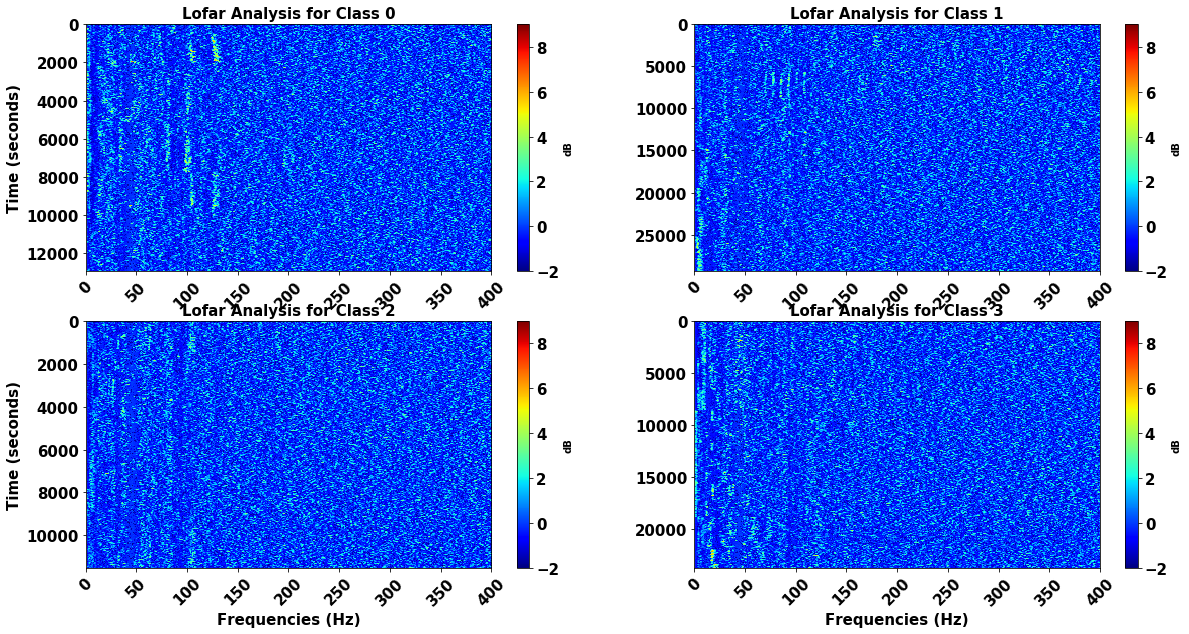

In [35]:
# LOFARGram for reconstructed input with lines
current_analysis = 'LOFARGram_reconstruction_first_layer'

# Choose num of neurons
ineuron = 400

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)

    ineuron = 400

    # Get the model file
    model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                               model_prefix_str,
                                               n_folds,
                                               params_str,
                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    model = load_model(file_name)
    all_output = model.predict(norm_data)

    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i'%ifold+'_fold'+'_%i'%ineuron+'_neurons_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

TypeError: unhashable type

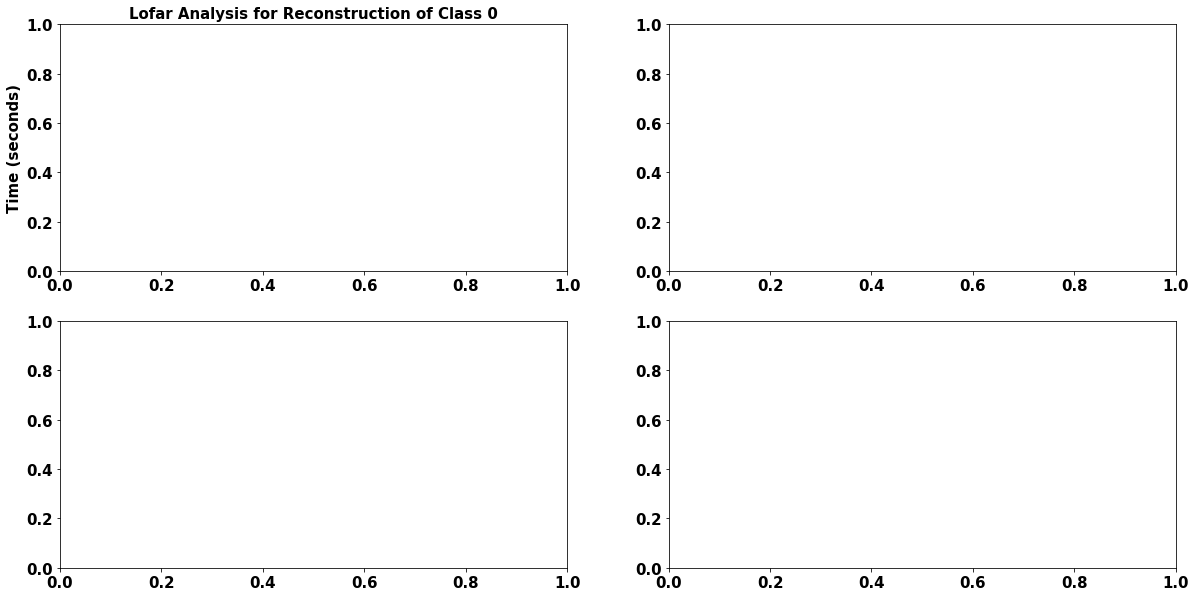

In [36]:
# LOFARGram for reconstructed input with lines
current_analysis = 'LOFARGram_reconstruction_first_layer'

# Choose num of lines to plot
points = 50

# Choose num of neurons
ineuron = 400

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)

    # Get the model file
    model_str = '%s/%s/%s_%i_folds_%s_400x%i_neurons'%(save_path,analysis_str,
                                               model_prefix_str,
                                               n_folds,
                                               params_str,
                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    model = load_model(file_name)
    all_output = model.predict(norm_data)

    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Reconstruction of Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        # Plot lines at frequencies with high errors
        for index in indexes[:points]:
            plt.axvline(index, color='r', alpha=0.7)

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 

    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%i'%points+'_points'+'_%i'%ifold+'_fold'+'_%i'%ineuron+'_neurons_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()

In [ ]:
# LOFARGram for original input
fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
for iclass, class_label in enumerate(class_labels):
    ax = plt.subplot(2,2,iclass+1)
    plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

    if iclass > 1:
        plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
    if ((iclass == 0) or (iclass==2)):
        plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

    plt.imshow(norm_data[all_trgt==iclass,:],
           cmap="jet",extent=[1, 400, norm_data[all_trgt==iclass,:].shape[0],1],
           aspect="auto")
    plt.xticks(np.linspace(0,400,9),rotation=45)
    cbar = plt.colorbar()
    plt.clim(-2,9)
    #if ((iclass == 1) or (iclass==3)):
    cbar.ax.set_ylabel('dB',fontweight='bold') 
#Save the figure
file_name = pict_results_path+'/LOFARGram_original.pdf'
plt.savefig(file_name)

## Análise de Classificação para a 1º Camada

In [26]:
%time
# Load Parameters
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear', # For AutoEncoder
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)
print trn_params.get_params_str()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


In [37]:
%time
def SAEClassificationtrainFold(ifold):
    return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                          trgt=all_trgt,
                                          ifold=ifold,
                                          n_folds=n_folds, 
                                          hidden_neurons=[400],
                                          trn_params=trn_params, 
                                          save_path=results_path,
                                          dev=development_flag)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.06 µs


In [38]:
%time

p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()

folds = range(len(CVO))
# To train on multiple cores sweeping the number of folds
results = p.map(SAEClassificationtrainFold, folds)

# To train on multiple cores sweeping the number of neurons
#results = p.map(trainNeuron, neurons)

p.close()
p.join()

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.06 µs
Fold 2 of 2 Folds -  Init 1 of 1 Inits
Fold 1 of 2 Folds -  Init 1 of 1 Inits
It took 261.834 seconds to perform the training


Topolgy (Classification_(400x400x4)_RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


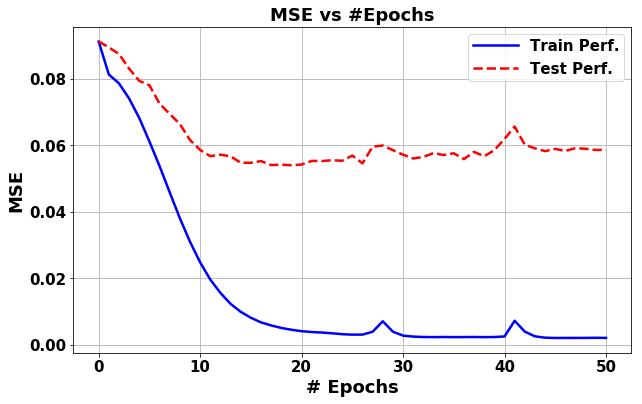

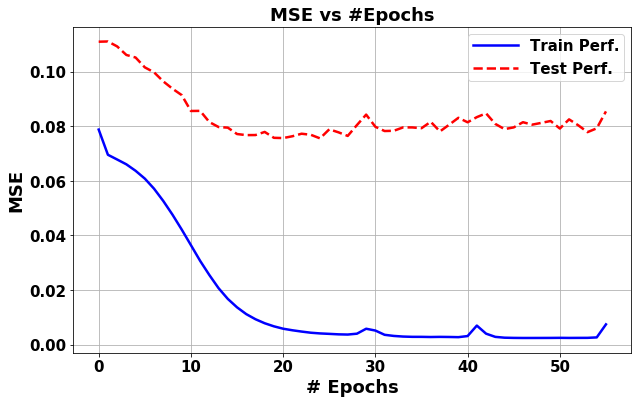

In [29]:
# Mean Squared Error x Epochs
%matplotlib inline  
import matplotlib.pyplot as plt

current_analysis = 'mse'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

hidden_neurons = [400]

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

# plot train updates
for ifold in range(len(CVO)):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rc('legend',**{'fontsize':15})
    plt.rc('font', weight='bold')
    
    fig1 = plt.figure(figsize=(10,6))
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    [trn_desc] = joblib.load(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()
    #Save the figure
    file_name = pict_results_path+'/Classification_(%s)_'%neurons_str\
        +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topolgy (%s)'%topology

Topology (Classification_(400x400x4)_RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation)


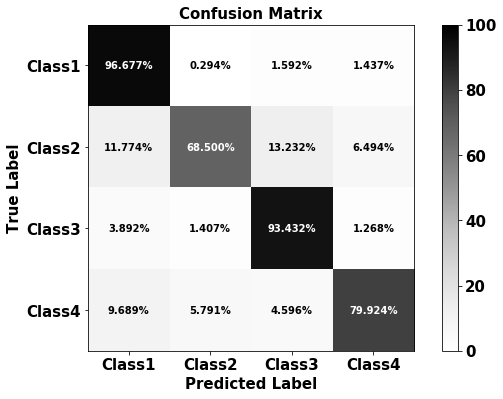

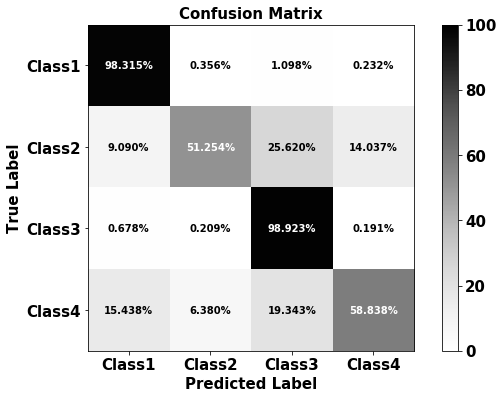

In [30]:
# Confusion Matrix

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'confusion_matrix'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

hidden_neurons = [400]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
        
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
    
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(norm_trgt, all_output)
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Histogram

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'histogram'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400]
analysis_full_data = True
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']
    
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=0)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Kernel Density

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'kernel_density'

hidden_neurons = [400]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name 
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Classification Report

# Choose Topology
hidden_neurons = [250]
analysis_full_data = True

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)
params_str = trn_params.get_params_str()

neurons_str = '400'
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])

print "Results for (%s) neurons (%s)"%(neurons_str, params_str)

if analysis_full_data:
    print 'Analysis in All Data'
    
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    
    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
        norm_trgt_sparse = trgt_sparse
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
        norm_trgt_sparse = trgt_sparse[test_id]
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    num_classes = len(class_labels.keys())
    
    efficiency = sklearn.metrics.recall_score(norm_trgt_sparse, np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = sklearn.metrics.precision_score(norm_trgt_sparse, np.round(output), average=None)
    f1_score = sklearn.metrics.f1_score(norm_trgt_sparse, np.round(output), average=None)
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index

# Treinamento da 2ª Camada

In [ ]:
%%time

hidden_neurons = [400]

# To train on multiple cores sweeping the number of folds
def trainFold(ifold):
    ineuron = 20
    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                trgt=all_data,
                                ifold=ifold,
                                n_folds=n_folds, 
                                n_neurons=ineuron,
                                trn_params=trn_params, 
                                save_path=results_path,
                                dev=development_flag,
                                layer = 2,
                                hidden_neurons = hidden_neurons)
    
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag,
                            layer = 2,
                            hidden_neurons = hidden_neurons)

In [ ]:
%time
p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()
folds = range(len(CVO))
neurons = range(0, 450, 75) # Train from 0 to 300
# To train on multiple cores sweeping the number of folds
#results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

   # Análise da variação do número de neurônios na segunda camada

In [ ]:
# Neuron variation x MSE

from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mse'

hidden_neurons = [400]
neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
analysis_file_name='%s/%s/%s_%s_second_layer_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)

#os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                             hidden_activation='tanh',
                                                             output_activation='linear',
                                                             n_epochs=500,
                                                             patience=30,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    neurons_mat = neurons
    neurons_mat.sort()
    
    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data[test_id,:])
        
        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1
            model_str = '%s/%s/%s_%i_folds_%s_%sx%i_neurons'%(save_path,analysis_str,
                                                       model_prefix_str,
                                                       n_folds,
                                                       params_str,neurons_str,
                                                       neuron_value)

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
            print file_name
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = neuron_value
                    return TrainFunctions.StackedAutoEncoderTrainFunction(data=all_data,
                                            trgt=all_data,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag,
                                            layer=2,
                                            hidden_neurons = hidden_neurons)
                
                p = multiprocessing.Pool(processes=num_processes)
                folds = range(len(CVO))
                results = p.map(trainFold, folds)
                p.close()
                p.join()
                
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = metrics.mean_squared_error(norm_data, output)
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 
ax.grid()
#Save the figure
file_name = pict_results_path+'/'+current_analysis+'_second_layer_'+trn_params.get_params_str()+'.pdf'
plt.savefig(file_name)
print "Topology (%s)"%trn_params.get_params_str()


# LOFARGram

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

# LOFARGram for reconstructed input
current_analysis = 'LOFARGram_reconstruction_second_layer'

# Choose num of neurons
hidden_neurons = [400, 200]

# Create a string like InputDimension x FirstLayerDimension x ... x OutputDimension
neurons_str = '400'
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(all_data.shape[1])

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)
    
    # First Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[0])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the first layer weights
    first_layer_model = load_model(file_name)
    encoder_first_layer = first_layer_model.layers[0].get_weights()
    decoder_first_layer = first_layer_model.layers[2].get_weights()
    
    # Second Layer
    previous_model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                            prefix_str,
                                                            n_folds,
                                                            params_str,
                                                            hidden_neurons[1])

    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(previous_model_str, ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str, ifold)
    # Get the second layer projection of data
    second_layer_model = load_model(file_name)
    encoder_second_layer = second_layer_model.layers[0].get_weights()
    decoder_second_layer = second_layer_model.layers[2].get_weights()
    
    model = Sequential()
    # Encoder
    model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=encoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    model.add(Dense(hidden_neurons[1], weights=encoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['hidden_activation']))
    # Decoder
    model.add(Dense(hidden_neurons[0], weights=decoder_second_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation']))
    model.add(Dense(norm_data.shape[1], weights=decoder_first_layer, trainable=False))
    model.add(Activation(trn_params.params['output_activation'], trainable=False))
    #model.summary()
    all_output = model.predict(norm_data)
    
    m_fontsize = 15

    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,10))
    for iclass, class_label in enumerate(class_labels):
        ax = plt.subplot(2,2,iclass+1)
        plt.title('Lofar Analysis for Class %s'%(class_label), fontsize= m_fontsize, fontweight="bold")

        if iclass > 1:
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
        if ((iclass == 0) or (iclass==2)):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")

        plt.imshow(all_output[all_trgt==iclass,:],
               cmap="jet",extent=[1, 400, all_output[all_trgt==iclass,:].shape[0],1],
               aspect="auto")
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_(%s)'%neurons_str+'_%i'%ifold+'_fold'+'_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

# Análise de Classificação para segunda camada

In [ ]:
%time
# Load Parameters
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear', # For AutoEncoder
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

In [ ]:
%time
from Functions import TrainFunctions
def SAEClassificationtrainFold(ifold):
    return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                          trgt=all_trgt,
                                          ifold=ifold,
                                          n_folds=n_folds, 
                                          hidden_neurons=(400,300),
                                          trn_params=trn_params, 
                                          save_path=results_path,
                                          dev=development_flag)

In [ ]:
%time

p = multiprocessing.Pool(processes=num_processes)
start_time = time.time()

folds = range(len(CVO))
# To train on multiple cores sweeping the number of folds
results = p.map(SAEClassificationtrainFold, folds)

# To train on multiple cores sweeping the number of neurons
#results = p.map(trainNeuron, neurons)

p.close()
p.join()

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

# Análise de Classificação com a segunda camada

In [ ]:
# Mean Squared Error x Epochs
%matplotlib inline  
import matplotlib.pyplot as plt

current_analysis = 'mse'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

hidden_neurons = [400,200]

# Parameters
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

# plot train updates
for ifold in range(len(CVO)):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rc('legend',**{'fontsize':15})
    plt.rc('font', weight='bold')
    
    fig1 = plt.figure(figsize=(10,6))
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    model_str = '%s/%s/Classification_(%s)_%s_%i_folds_%s'%(save_path,analysis_str,
                                                            neurons_str,
                                                            prefix_str, n_folds,
                                                            params_str)

    if not development_flag:        
        load_file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    [trn_desc] = joblib.load(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()
    #Save the figure
    file_name = pict_results_path+'/Classification_(%s)_'%neurons_str\
        +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)

In [ ]:
# Confusion Matrix

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'confusion_matrix'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path


hidden_neurons = [400, 200]
analysis_full_data = True

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear', # for autoencoders
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
    

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
    
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(norm_trgt, all_output)
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Histogram

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'histogram'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,200]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='linear',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']
    
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=0)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Kernel Density

%matplotlib inline  
from sklearn import preprocessing
import matplotlib.pyplot as plt

current_analysis = 'kernel_density'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,200]
analysis_full_data = True

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=30,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    if analysis_full_data:
        norm_data = scaler.transform(all_data)
        norm_trgt = all_trgt
    else: 
        norm_data = scaler.transform(all_data[test_id, :])
        norm_trgt = all_trgt[test_id]
    
    neurons_str = str(all_data.shape[1])
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name 
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[norm_trgt==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
    
    #Save the figure
    if analysis_full_data:
        file_name = pict_results_path+'/Classification_(%s)_all_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    else: 
        file_name = pict_results_path+'/Classification_(%s)_test_data_'%neurons_str\
            +current_analysis+'_%i'%ifold+'_fold_'+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print 'Topology (%s)'%topology
if analysis_full_data:
    print 'Analysis in All Data'

In [ ]:
# Classification Report

current_analysis = 'report'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Choose Topology
hidden_neurons = [400,200]
analysis_full_data = False

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)
params_str = trn_params.get_params_str()

neurons_str = str(all_data.shape[1])
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])

print "Results for (%s) neurons (%s)"%(neurons_str, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
    # Check if the topology has already been trained    
    if not os.path.exists(load_file_name):
        def SAEClassificationTrainFold(ifold):
            return TrainFunctions.SAEClassificationTrainFunction(data=all_data,
                                                  trgt=all_trgt,
                                                  ifold=ifold,
                                                  n_folds=n_folds, 
                                                  hidden_neurons=hidden_neurons,
                                                  trn_params=trn_params, 
                                                  save_path=results_path,
                                                  dev=development_flag)
           
        p = multiprocessing.Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    num_classes = len(class_labels.keys())
    
    efficiency = sklearn.metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = sklearn.metrics.precision_score(trgt_sparse[test_id], np.round(output), average=None)
    f1_score = sklearn.metrics.f1_score(trgt_sparse[test_id], np.round(output), average=None)
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index
   

# Treinamento da 3ª Camada